In [1]:
import numpy as np
import colorsys
import h5py
from PIL import Image
import io
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [6]:
!/ccn2/u/thekej/miniconda3/bin/python -m pip install opencv-python

  Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 51.7 MB/s eta 0:00:00:00:0100:01
Using cached numpy-1.26.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


In [7]:
def unproject_pixels(pts, depth, cam_matrix, vfov=55, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''

    
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    points_in_cam = points_in_cam[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def pad_ones(pts):
    '''
    pts: [N , K]
    returns: [N, K+1]
    '''
    pw = np.concatenate([pts, np.ones([pts.shape[0], 1])], 1)
    return pw


def proj_world_to_pixel(pw, cam_matrix, proj_matrix):
    '''
    pw: [N, 3] world coords
    cam_matrix: [4, 4] cam matrix
    proj_matrix: [4, 4] proj matrix
    returns: [N, 2] pixel coords
    '''
    t = time.time()
    matrix = np.matmul(proj_matrix, cam_matrix)
    
    pw = pad_ones(pw).T
    
    proj_pts = np.matmul(matrix, pw).T
    
    depth = proj_pts[:, 3]

    proj_pts = proj_pts/proj_pts[:, 3:4]

    proj_pts = proj_pts.clip(-1, 1)


    proj_pts = (proj_pts + 1)/2
    
    proj_pts = proj_pts[:, :2]

    proj_pts[:, 1] = 1 - proj_pts[:, 1]

    proj_pts = proj_pts[:, [1, 0]]

    proj_pts = (proj_pts*1023).astype(int)
    
    print("time:", time.time() - t)
    
    return proj_pts, depth

import numpy as np
import matplotlib.pyplot as plt

def get_square(center, num_points, rnge=1):
    '''
    center: [x, z, y]
    '''
    # Define the number of points along each side
    
    center_xy = center[[0, 2]]
    
    bnd = rnge/2

    # Create a grid of x and y values between -1 and 1
    x = np.linspace(-bnd, bnd, num=num_points)
    y = np.linspace(-bnd, bnd, num=num_points)
    X, Y = np.meshgrid(x, y)

    # Create a mask for the points inside the square
    mask = (X >= -1) & (X <= 1) & (Y >= -1) & (Y <= 1)

    # Select the points inside the square
    points = np.column_stack([X[mask], Y[mask]])
    
#     print(center_xy)
#     
    points = points + center_xy[None, :]
    
    points = pad_ones(points)
    
    points[:, 2] = center[1]
    
    points = points[:, [0, 2, 1]]
    
    return points


def random_point_in_triangle(v1, v2, v3):
    """Return a random point in the triangle defined by v1, v2, v3."""
    s, t = sorted([np.random.random(), np.random.random()])
    return (s * v1[0] + (t-s)*v2[0] + (1-t)*v3[0],
            s * v1[1] + (t-s)*v2[1] + (1-t)*v3[1])

def get_disc(center, num_points=1000, rnge=1):
    """Generate a point cloud for an upright triangular prism."""
    # Define vertices of the base triangle
    xc, yc, zc = center
    base_triangle = np.array([[xc, zc, yc], [xc+0.2, zc, yc], [xc, zc+0.2, yc]])

    # Define height of the prism
    height = 0.7

    # Generate points
    points = []
    for _ in range(num_points):
        base_point = random_point_in_triangle(*base_triangle)
        x = base_point[0]
        y = base_point[1]
        z = np.random.random() * height  # Random height
        
        points.append([x, y, z])

    return np.array(points)[:, [0, 2, 1]]



def sample_point_on_line_segment(v1, v2):
    """Return a random point on the line segment defined by v1 and v2."""
    t = np.random.random()
    return v1 + t * (v2 - v1)

def get_disc_edges(center, num_points=1000, rnge=1):
    """Generate a point cloud for the edges of an upright triangular prism."""
    # Define vertices of the base triangle
    xc, yc, zc = center
    base_triangle = np.array([[xc, zc, yc], [xc+0.2, zc, yc], [xc, zc+0.2, yc]])

    # Define height of the prism
    height = 0.7
    top_triangle = base_triangle + [0, 0, height]

    # Edges of the prism
    edges = [
        (base_triangle[0], base_triangle[1]),
        (base_triangle[1], base_triangle[2]),
        (base_triangle[2], base_triangle[0]),
        (top_triangle[0], top_triangle[1]),
        (top_triangle[1], top_triangle[2]),
        (top_triangle[2], top_triangle[0]),
        (base_triangle[0], top_triangle[0]),
        (base_triangle[1], top_triangle[1]),
        (base_triangle[2], top_triangle[2]),
    ]

    # Sample points along the edges
    points = []
    for edge in edges:
        for _ in range(num_points):
            point = sample_point_on_line_segment(edge[0], edge[1])
            points.append(point)

    return np.array(points)[:, [0, 2, 1]]



def filter_occluded(pts, im_seg, color, depth_map, depth_sq, square_ids):
    '''
    pts: [N, 2] pixel coords
    returns: [K < N, 2] unoccluded coords
    '''

    target = (im_seg ==  color[None, None, :]).all(-1).astype('float')

    im_seg = (im_seg >0).any(-1).astype('float')

    im_seg = im_seg - target
    
    im_seg = im_seg > 0
    
    im_seg = ~im_seg
    
    valid = im_seg[pts[:, 0], pts[:, 1]]
    
    valid_depth = depth_map[pts[:, 0], pts[:, 1]] > depth_sq
        
    valid = valid | valid_depth
    
    return pts[valid], square_ids[valid], im_seg

**Get cam and proj matrices**

In [59]:
# file_path = '/ccn2/u/rmvenkat/data/testing_physion/gen_full_data_depth_512/lf_0/collide_all_movies/pilot_it2_collision_assorted_targets_box/0001.hdf5'

file_path = '/ccn2/u/rmvenkat/data/testing_physion/regenerate_from_old_commit//test_consolidated/data_balanced/link_all_movies/pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0027.hdf5'

h5file = h5py.File(file_path, 'r')

cam_matrix = h5file['frames']['0000']['camera_matrices']['camera_matrix_cam0'][:]

cam_matrix = cam_matrix.reshape(4, 4)

proj_matrix = h5file['frames']['0000']['camera_matrices']['projection_matrix_cam0'][:]

proj_matrix = proj_matrix.reshape(4, 4)



**View image, segmentation colors and depth map**

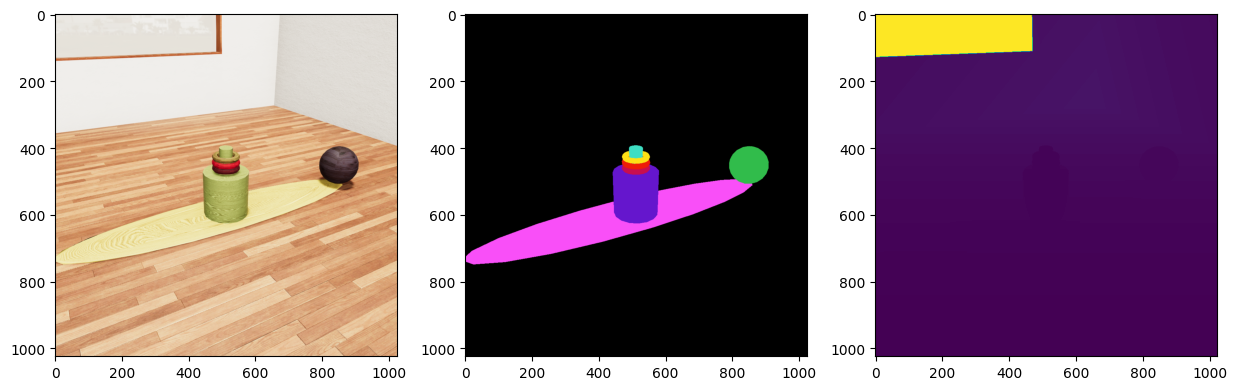

In [60]:
im = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_img_cam0'][:])))

im_seg = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_id_cam0'][:])))
colors = h5file['static']['object_segmentation_colors'][:][0]

depth_map = np.array(h5file['frames']['0000']['images']['_depth_cam0'])

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(131)
ax.imshow(im)

ax = fig.add_subplot(132)
ax.imshow(im_seg)

ax = fig.add_subplot(133)
ax.imshow(depth_map)

In [61]:
import cv2
import numpy as np

def find_upper_left_corner_opencv(im_seg, color):
    # Create a binary mask where the color matches the mat's color
    color_mask = np.all(im_seg == color, axis=-1).astype(np.uint8) * 255
    
    # Find contours from the binary mask
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the mat
    if contours:
        mat_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.01 * cv2.arcLength(mat_contour, True)
        approx = cv2.approxPolyDP(mat_contour, epsilon, True)
        
        # Find the upper left corner based on the approximated contour
        if len(approx) >= 4:
            upper_left_corner = sorted(approx[:, 0, :], key=lambda x: x[0] + x[1])[0]
        else:
            upper_left_corner = [0, 0]  # Fallback if contour is not as expected
    else:
        upper_left_corner = [0, 0]  # Fallback if no contours are found
    
    return tuple(upper_left_corner)

def find_center_opencv(im_seg, color):
    # Create a binary mask where the color matches the mat's color
    color_mask = np.all(im_seg == color, axis=-1).astype(np.uint8) * 255
    
    # Find contours from the binary mask
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour corresponds to the mat
    if contours:
        mat_contour = max(contours, key=cv2.contourArea)
        
        # Calculate the centroid of the contour
        M = cv2.moments(mat_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            center = (cX, cY)
        else:
            center = (0, 0)  # Fallback if contour is degenerate
    else:
        center = (0, 0)  # Fallback if no contours are found
    
    return center

**Overlay disc**

In [62]:
disc_radius = 10
x, y = 500, 500
num_samp =500

im_cpy = im.copy()

pts = np.array([[x, y]])
depth = depth_map[pts[:, 0], pts[:, 1]]
pw = unproject_pixels(pts, depth, cam_matrix)

pw_square = get_square(pw[0], num_samp, rnge=disc_radius)

pixel_coord_recon_square, depth_sq = proj_world_to_pixel(pw_square, cam_matrix, proj_matrix)

pixel_coord_recon_square_, valid_img = filter_occluded(pixel_coord_recon_square, im_seg, colors, depth_map, depth_sq)

for pt in pixel_coord_recon_square:
    im_cpy[pt[0]:pt[0]+1, pt[1]:pt[1]+1] = [255, 0, 0]
    
    
#pw_square = get_disc_edges(pw[0], num_samp, rnge=disc_radius)

#pixel_coord_recon_square, depth_sq = proj_world_to_pixel(pw_square, cam_matrix, proj_matrix)

#pixel_coord_recon_square_, valid_img = filter_occluded(pixel_coord_recon_square, im_seg, colors, depth_map, depth_sq)

#for pt in pixel_coord_recon_square_:
#    im_cpy[pt[0]:pt[0]+1, pt[1]:pt[1]+1] = [0, 0, 0]

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121)
ax.imshow(im)

ax = fig.add_subplot(122)
ax.imshow(im_cpy)

time: 0.000545501708984375


TypeError: filter_occluded() missing 1 required positional argument: 'square_ids'

## Overlay Checkerboard

In [63]:
def get_full_checkerboard_with_ids(upper_left, num_points, rnge=1, square_size=0.1):
    start_x, _, start_z = upper_left
    end_x = start_x + rnge
    end_z = start_z - rnge  # Assuming a top-down view, z decreases as we go down

    x = np.linspace(start_x, end_x, num=num_points)
    z = np.linspace(start_z, end_z, num=num_points)
    X, Z = np.meshgrid(x, z)

    # Calculate square IDs based on position; every square gets an ID
    square_id_x = np.floor((X - start_x) / square_size).astype(int)
    square_id_z = np.floor((start_z - Z) / square_size).astype(int)
    square_ids = square_id_x + square_id_z * (int(rnge / square_size))
    
    # Every square gets included, no filtering based on checkerboard pattern
    points = np.column_stack([X.flatten(), np.full(X.size, upper_left[1]), Z.flatten()])
    flat_square_ids = square_ids.flatten()

    return points, flat_square_ids


def get_full_checkerboard_with_ids_center(center, num_points, rnge=1, square_size=0.1):
    center_x, _, center_z = center
    # Adjust start_x and start_z to account for the checkerboard center
    start_x = center_x - rnge / 2
    start_z = center_z + rnge / 2  # Note: Assuming a top-down view, z decreases as we go down

    end_x = center_x + rnge / 2
    end_z = center_z - rnge / 2

    x = np.linspace(start_x, end_x, num=num_points)
    z = np.linspace(end_z, start_z, num=num_points)  # Swap start_z and end_z to ensure correct ordering
    X, Z = np.meshgrid(x, z)

    # Calculate square IDs based on position; every square gets an ID
    square_id_x = np.floor((X - start_x) / square_size).astype(int)
    square_id_z = np.floor((start_z - Z) / square_size).astype(int)
    square_ids = square_id_x + square_id_z * (int(rnge / square_size))
    
    # Every square gets included, no filtering based on checkerboard pattern
    points = np.column_stack([X.flatten(), np.full(X.size, center[1]), Z.flatten()])
    flat_square_ids = square_ids.flatten()

    return points, flat_square_ids


[[627 411]]
time: 0.18024110794067383


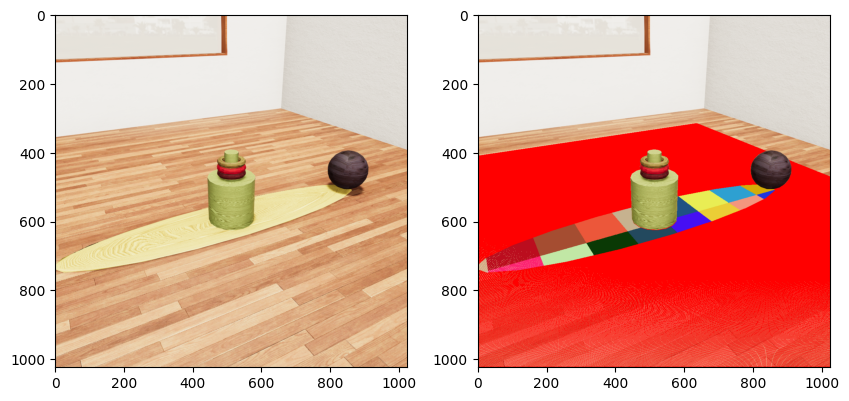

In [68]:
y, x = find_center_opencv(im_seg, colors)
#y, x = find_upper_left_corner_opencv(im_seg, colors)
num_samp =2000

im_cpy = im.copy()

pts = np.array([[x, y]])
print(pts)
depth = depth_map[pts[:, 0], pts[:, 1]]
pw = unproject_pixels(pts, depth, cam_matrix)

pw_square, square_ids = get_full_checkerboard_with_ids_center(pw[0], num_samp, rnge=5, square_size=0.35)
#get_full_checkerboard_with_ids(pw[0], num_samp, rnge=5, square_size=0.2)
#get_checkerboard_with_ids(pw[0], num_samp, rnge=5, square_size=0.4)

# Project world points to pixel coordinates and get depth
pixel_coord_recon_square, depth_sq = proj_world_to_pixel(pw_square, cam_matrix, proj_matrix)

#valid_ids = square_ids[:, np.newaxis]

# Filter occluded points
pixel_coord_recon_square_, valid_ids, valid_img = filter_occluded(pixel_coord_recon_square, im_seg, colors, depth_map, depth_sq, square_ids)

# Assign a unique color to each square ID
unique_ids = np.unique(valid_ids)
colors_for_ids = {uid: np.random.randint(0, 255, (3,)) for uid in unique_ids}  # Random color for each ID
#print(valid_ids, pixel_coord_recon_square_)
# Color the points in the image based on their square ID

for pt in pixel_coord_recon_square_:
    im_cpy[pt[0]:pt[0]+1, pt[1]:pt[1]+1] = [255, 0, 0]

color_matches = np.all(im_seg[pixel_coord_recon_square_[:, 0], pixel_coord_recon_square_[:, 1]] == colors, axis=-1)

# Filter points and IDs based on color match
valid_points = pixel_coord_recon_square_[color_matches]
valid_ids_filtered = valid_ids[color_matches]

# Assign colors based on IDs using advanced indexing
for id_ in np.unique(valid_ids_filtered):
    id_mask = valid_ids_filtered == id_
    points_for_id = valid_points[id_mask]
    color = colors_for_ids[id_]
    im_cpy[points_for_id[:, 0], points_for_id[:, 1]] = color

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121)
ax.imshow(im)

ax = fig.add_subplot(122)
ax.imshow(im_cpy)

In [64]:
def get_checkerboard(center, num_points, rnge=1, square_size=0.1):
    center_xy = center[[0, 2]]  # Use X and Z as the plane
    
    bnd = rnge / 2
    
    x = np.linspace(center_xy[0] - bnd, center_xy[0] + bnd, num=num_points)
    z = np.linspace(center_xy[1] - bnd, center_xy[1] + bnd, num=num_points)
    X, Z = np.meshgrid(x, z)

    checkerboard_pattern = ((np.floor(X / square_size) + np.floor(Z / square_size)) % 2 == 0)

    points = np.column_stack([X[checkerboard_pattern], np.full(np.sum(checkerboard_pattern), center[1]), Z[checkerboard_pattern]])

    return points
